In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import src.models.models
import os

## This file explores the data statistically and also yielded the data cleaning framework as well as the normalisation process for continuous columns of the dataset.

In [ ]:
def data_cleaning(file_name):
    csv_path = os.path.join("data","raw",f'{file_name}')
    df = pd.read_csv(csv_path)
    df = df.set_index("id")
    df["age"] = df["age"] / 365
    df["age"] =df["age"].astype(int)
    df.dropna()
    
    count = 0
    while ( ((df['ap_hi'] < 50) | (df['ap_hi'] > 250) | (df['ap_lo'] < 30) | (df['ap_lo'] > 160)) .any()) | count < 10:
        df.loc[df['ap_hi'] < 50, 'ap_hi'] *= 10
        df.loc[df['ap_hi'] > 250, 'ap_hi'] //= 10
        df.loc[df['ap_lo'] < 30, 'ap_lo'] *= 10
        df.loc[df['ap_lo'] > 160, 'ap_lo'] //= 10
        count += 1

    invalid_bp = ( (df['ap_hi'] < 50) | (df['ap_hi'] > 250) | (df['ap_lo'] < 30) | (df['ap_lo'] > 160) | (df['ap_hi'] < df['ap_lo']) )
    df = df.drop(df[invalid_bp].index)
    return df

def data_normalization(X_train, X_pred):
    scaler = StandardScaler()
    continuous = ["age", "height", "weight", "ap_hi", "ap_lo"]
    X_train[continuous] = scaler.fit_transform(X_train[continuous])
    X_pred[continuous] = scaler.transform(X_pred[continuous])
    return X_train, X_pred


In [123]:
csv_path = os.path.join("data","raw","cardio_train.csv")
expl1 = pd.read_csv(csv_path)
expl1 = expl1.set_index("id")
expl1["age"] = expl1["age"] / 365
expl1["age"] =expl1["age"].astype(int)
data_na = expl1[expl1.isna().any(axis=1)]
expl1.dropna()
expl1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [124]:
expl1.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.766774,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


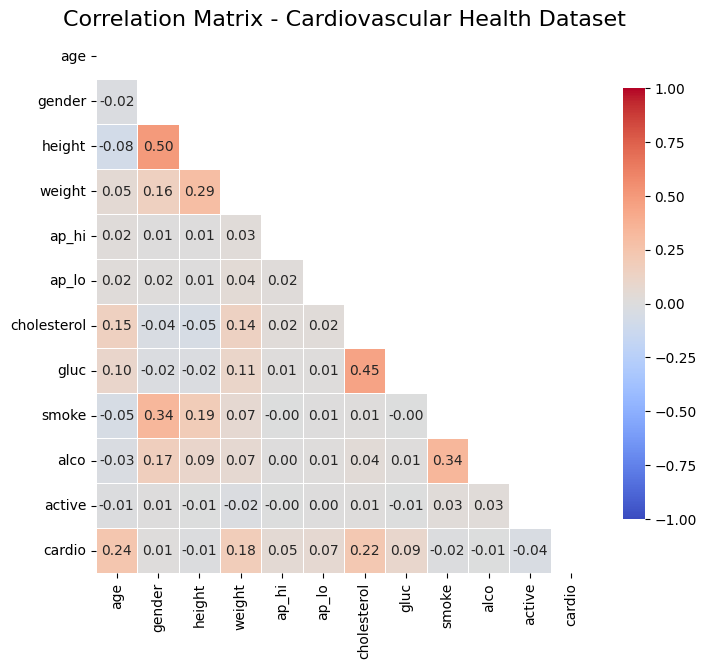

In [125]:
corr = expl1.corr()
plt.figure(figsize=(8, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            mask=mask, 
            annot=True,      # Show the numbers in the boxes
            fmt=".2f",       # Format numbers to 2 decimal places
            cmap='coolwarm', # Red for positive, Blue for negative
            vmax=1,          # Max value for color scale
            vmin=-1,         # Min value for color scale
            center=0,        # Center color scale at 0
            linewidths=.5,   # Add white lines between squares
            cbar_kws={"shrink": .8}) # Shrink the legend bar slightly

# 4. Add Title and Show
plt.title('Correlation Matrix - Cardiovascular Health Dataset', fontsize=16)
plt.yticks(rotation=0) # Ensure y-axis labels are horizontal
plt.show()

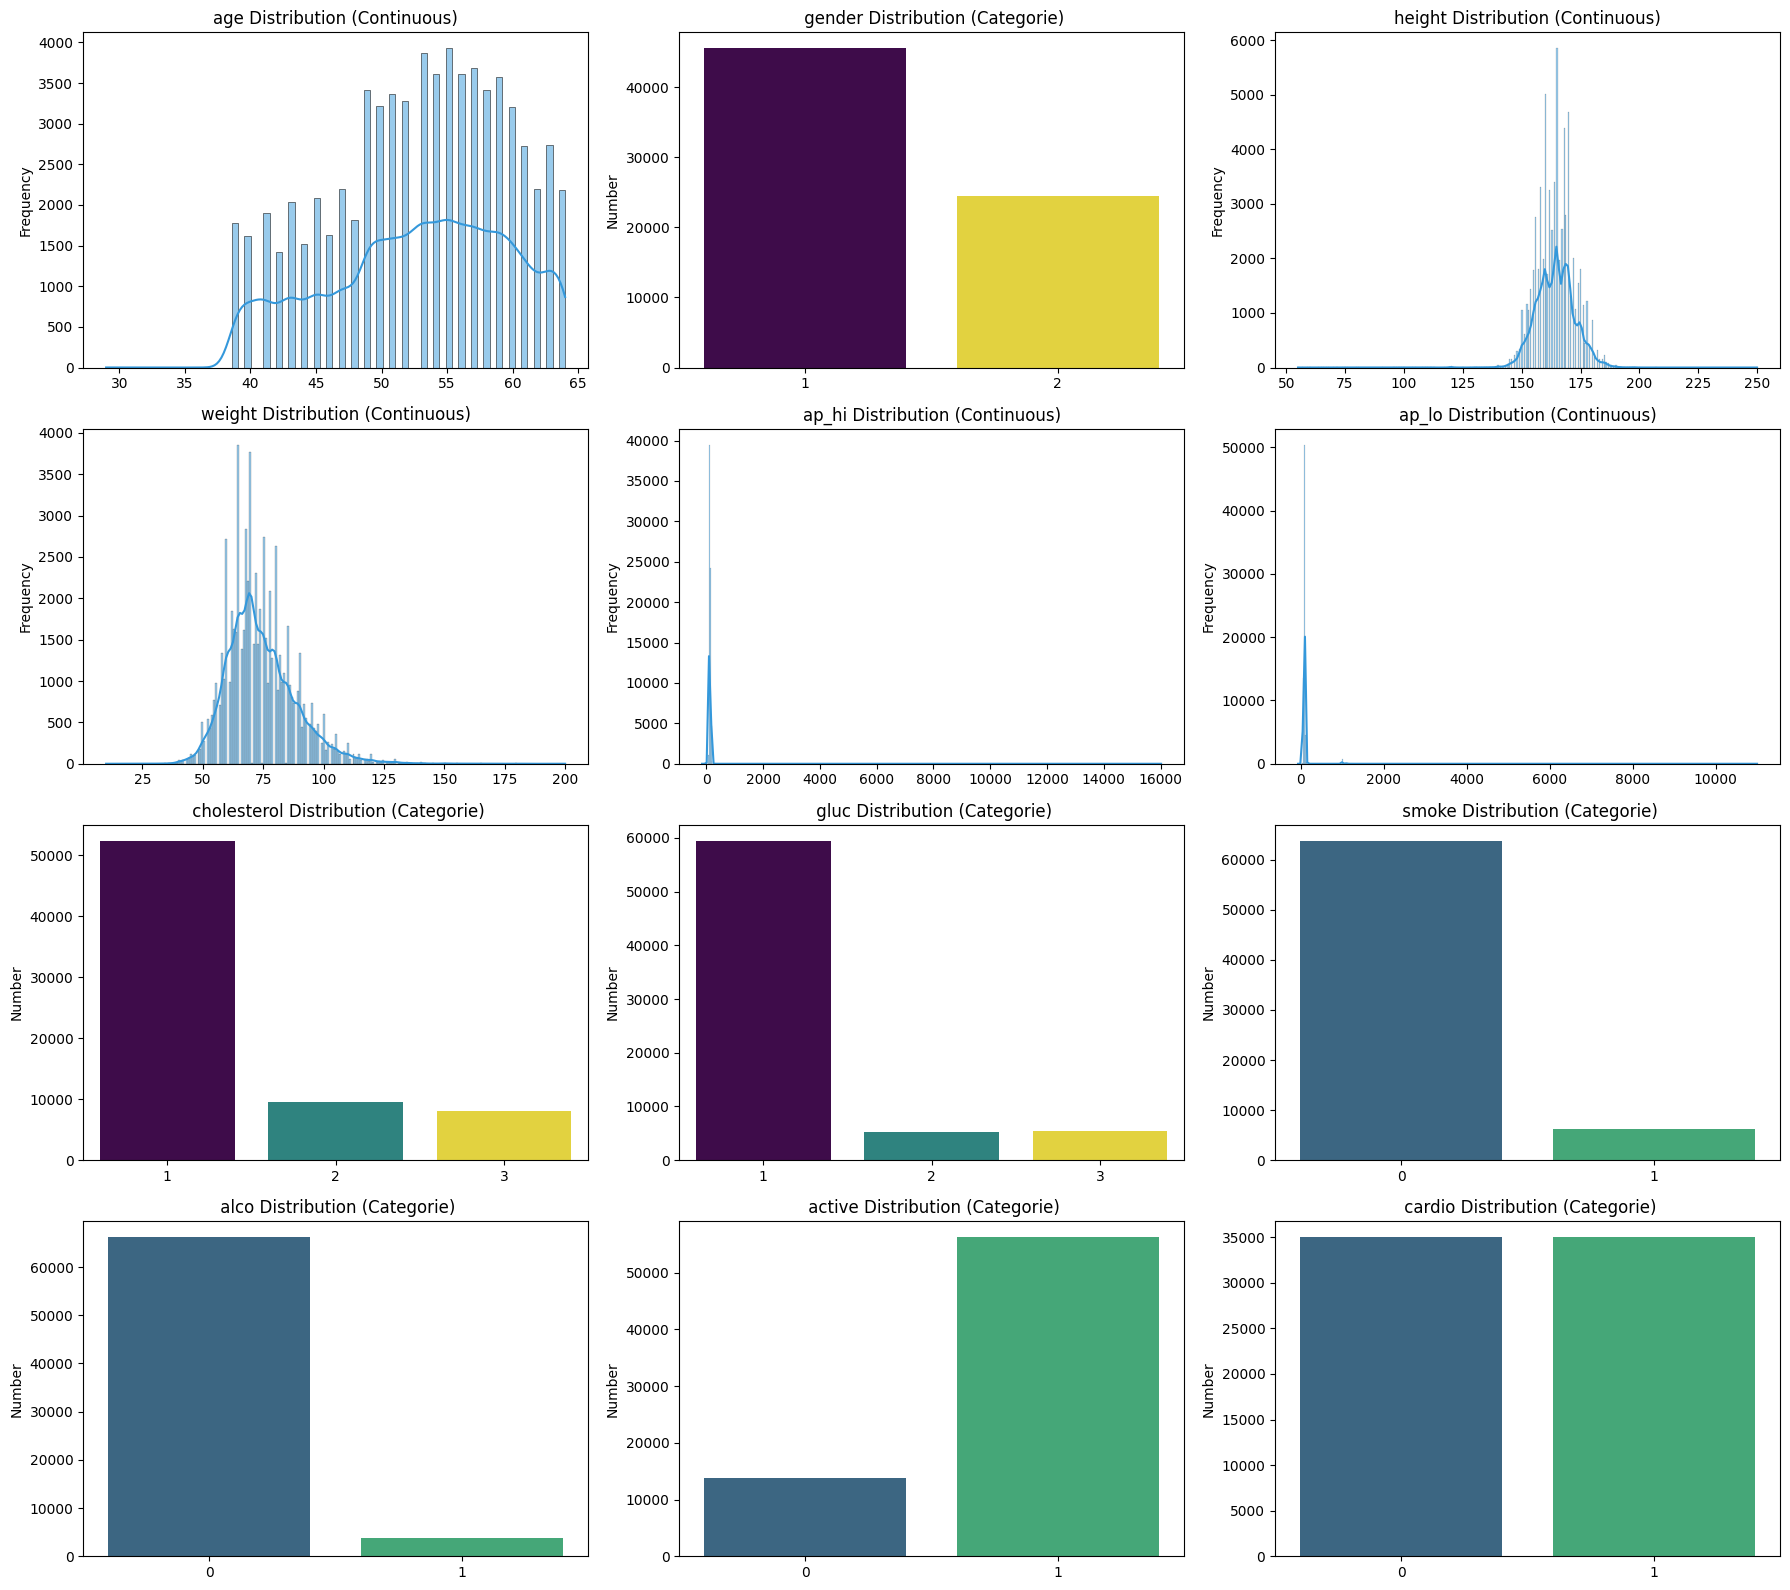

In [126]:
n_cols = 3  # Nombre de colonnes dans la grille
n_rows = (len(expl1.columns) + n_cols - 1) // n_cols # Calcul automatique des lignes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten() # Aplatir pour itérer facilement

# Boucle sur toutes les colonnes
for i, col in enumerate(expl1.columns):
    # Logique : Si moins de 10 valeurs uniques => Variable Catégorielle (Barplot)
    # Sinon => Variable Continue (Histogramme + Courbe de densité)
    if expl1[col].nunique() < 5:
        sns.countplot(data=expl1, x=col, ax=axes[i], hue=col, palette='viridis', legend=False)
        axes[i].set_title(f' {col} Distribution (Categorie)')
        axes[i].set_ylabel('Number')
    else:
        sns.histplot(data=expl1, x=col, kde=True, ax=axes[i], color='#3498db', edgecolor='black')
        axes[i].set_title(f'{col} Distribution (Continuous)')
        axes[i].set_ylabel('Frequency')
    
    axes[i].set_xlabel('') # Nettoyage visuel

# Supprimer les graphiques vides s'il y en a en trop dans la grille
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [127]:
# On garde uniquement les données qui respectent ces conditions
length = len(expl1)
expl1_wo_outliers = expl1[
    (expl1['ap_hi'] >= 50) & (expl1['ap_hi'] <= 250) & 
    (expl1['ap_lo'] >= 30) & (expl1['ap_lo'] <= 160) &
    (expl1['ap_hi'] > expl1['ap_lo'])  # La systolique doit être > diastolique
]

print(f"Lignes supprimées : {length - len(expl1_wo_outliers)}")
expl1_wo_outliers

Lignes supprimées : 1325


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,52,2,168,76.0,120,80,1,1,1,0,1,0
99995,61,1,158,126.0,140,90,2,2,0,0,1,1
99996,52,2,183,105.0,180,90,3,1,0,1,0,1


In [128]:
expl1bis = expl1[
    #(expl1['ap_hi'] <= 50) |
    #(expl1['ap_hi'] >= 250) |
    #(expl1['ap_lo'] <= 30) |
    #(expl1['ap_lo'] >= 160) |
    (expl1['ap_hi'] < expl1['ap_lo'])
]
expl1["ap_hi"].describe()


count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [137]:

expl2 = expl1.copy()
count = 0
while ( ((expl2['ap_hi'] < 50) | (expl2['ap_hi'] > 250) | (expl2['ap_lo'] < 30) | (expl2['ap_lo'] > 160)) .any()) | count < 10:
    expl2.loc[expl2['ap_hi'] < 50, 'ap_hi'] *= 10
    expl2.loc[expl2['ap_hi'] > 250, 'ap_hi'] //= 10
    expl2.loc[expl2['ap_lo'] < 30, 'ap_lo'] *= 10
    expl2.loc[expl2['ap_lo'] > 160, 'ap_lo'] //= 10
    count += 1
print(count)

expl3=expl2.copy() 
invalid_bp = ( (expl3['ap_hi'] < 50) | (expl3['ap_hi'] > 250) | (expl3['ap_lo'] < 30) | (expl3['ap_lo'] > 160) | (expl3['ap_hi'] < expl3['ap_lo']) )
expl3 = expl3.drop(expl3[invalid_bp].index)

10


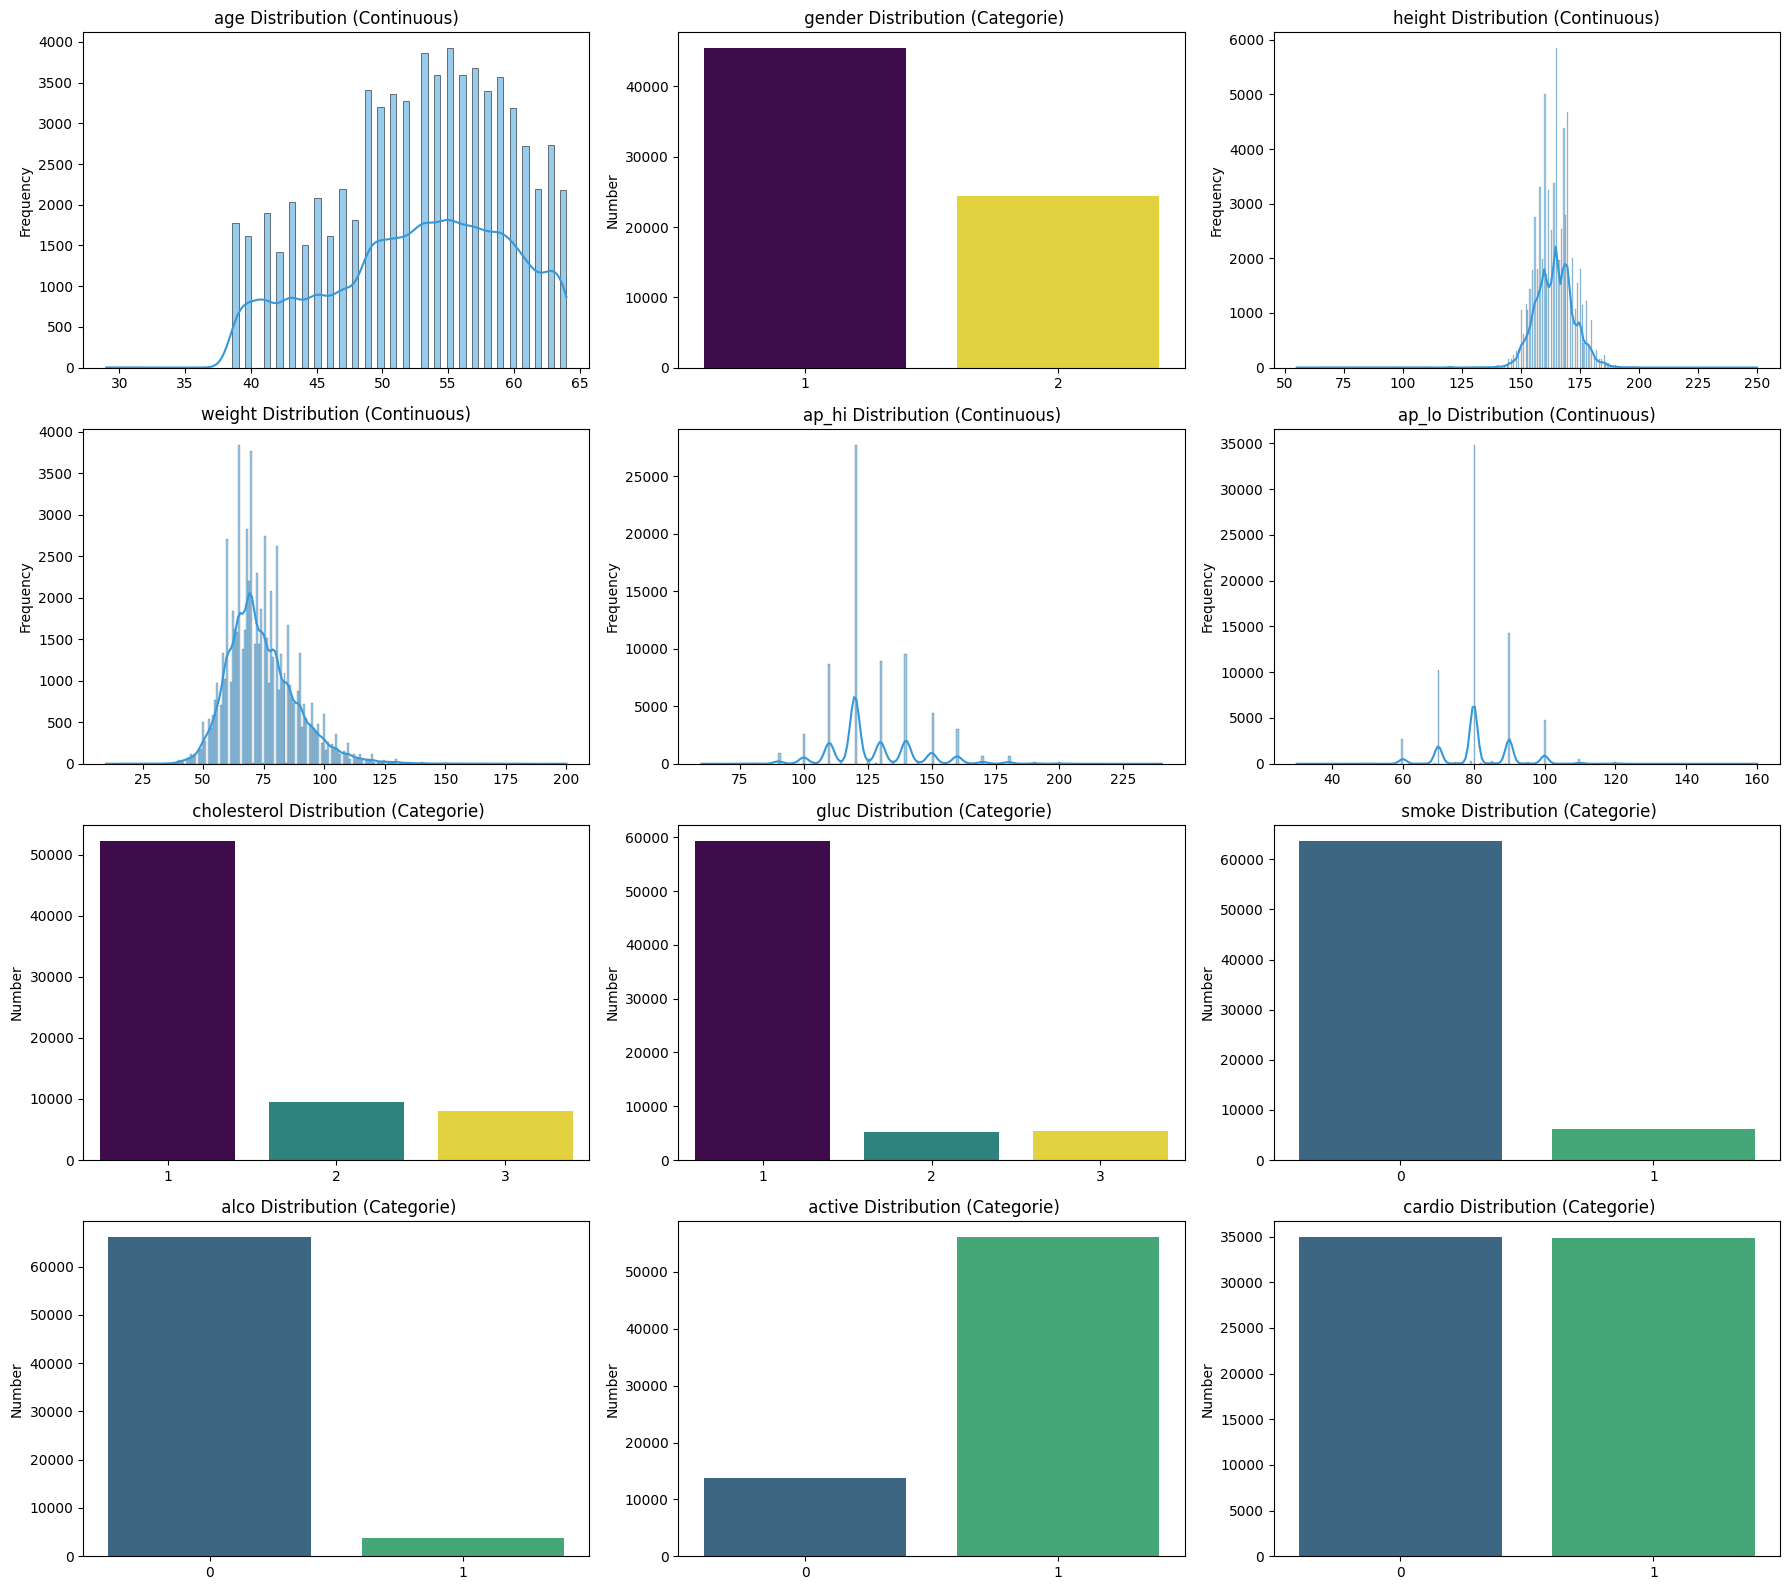

In [138]:
n_cols = 3  # Nombre de colonnes dans la grille
n_rows = (len(expl3.columns) + n_cols - 1) // n_cols # Calcul automatique des lignes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten() # Aplatir pour itérer facilement

# Boucle sur toutes les colonnes
for i, col in enumerate(expl3.columns):
    # Logique : Si moins de 10 valeurs uniques => Variable Catégorielle (Barplot)
    # Sinon => Variable Continue (Histogramme + Courbe de densité)
    if expl3[col].nunique() < 5:
        sns.countplot(data=expl3, x=col, ax=axes[i], hue=col, palette='viridis', legend=False)
        axes[i].set_title(f' {col} Distribution (Categorie)')
        axes[i].set_ylabel('Number')
    else:
        sns.histplot(data=expl3, x=col, kde=True, ax=axes[i], color='#3498db', edgecolor='black')
        axes[i].set_title(f'{col} Distribution (Continuous)')
        axes[i].set_ylabel('Frequency')
    
    axes[i].set_xlabel('') # Nettoyage visuel

# Supprimer les graphiques vides s'il y en a en trop dans la grille
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Normalization process
expl4 = expl3.copy()
continuous = ["age", "height", "weight", "ap_hi", "ap_lo"]
expl4[continuous] = (expl4[continuous] - expl4[continuous].mean()) / expl4[continuous].std()